In [2]:
!pip3 install xgboost #installing the Xgboost module

  Using cached xgboost-1.6.1-py3-none-manylinux2014_x86_64.whl (192.9 MB)


In [3]:
#Importing the necessary libararies for the analysis
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb

## Loading the data into the pandas dataframe

In [4]:
#reading the data using the pandas module
df=pd.read_csv("eth_15min.csv")
df=df.rename(columns={'Unnamed: 0': 'timestamp'})
df=df.set_index("timestamp") #setting the timestamp as index

## visualization of the final target 

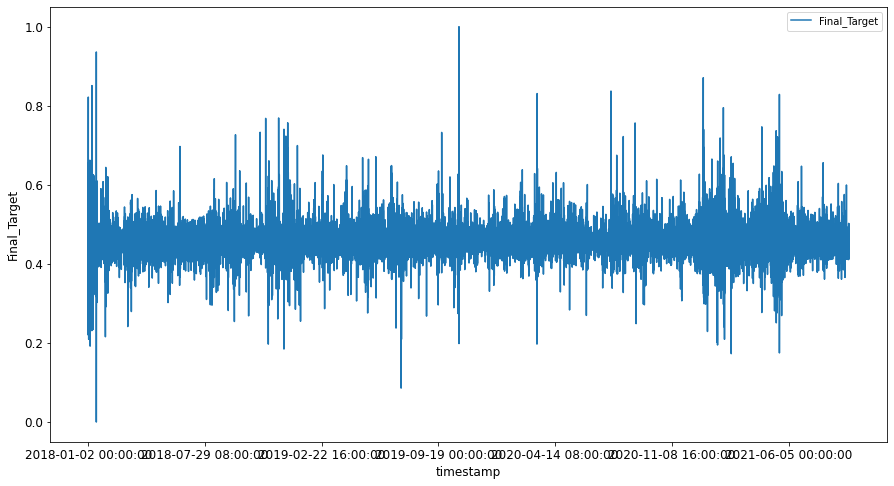

In [5]:
#visualization of the final target 
df.plot(y='Final_Target', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.show()

In [6]:
# univariate data: Final_target vs Time

uni_data_df = df['Final_Target']
uni_data_df.head()
uni_data_df.shape

(130370,)

In [7]:
uni_data_df.shape

(130370,)

In [8]:
#splitting the data into 70-30
train_start_dt = '2018-01-02'
test_start_dt = '2020-08-11'

## Data visualisation of train and test 

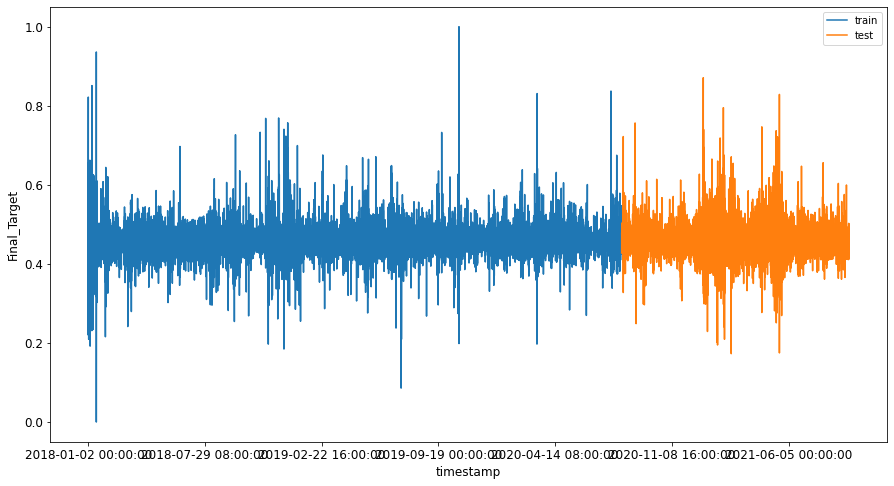

In [9]:
#data visualisation of train and test 
df[(df.index < test_start_dt) & (df.index >= train_start_dt)][['Final_Target']].rename(columns={'Final_Target':'train'}) \
    .join(df[test_start_dt:][['Final_Target']].rename(columns={'Final_Target':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.show()

In [10]:
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Final_Target']]
test = df.copy()[df.index >= test_start_dt][['Final_Target']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (91392, 1)
Test data shape:  (38978, 1)


In [11]:
train.head(10)

,Final_Target
timestamp,
2018-01-02 00:00:00,0.546330
2018-01-02 00:15:00,0.550354
2018-01-02 00:30:00,0.635160
2018-01-02 00:45:00,0.532988
2018-01-02 01:00:00,0.566638
2018-01-02 01:15:00,0.573950
2018-01-02 01:30:00,0.734319
2018-01-02 01:45:00,0.751294
2018-01-02 02:00:00,0.683291


In [12]:
test.shape

(38978, 1)

In [13]:
test.head(10)

,Final_Target
timestamp,
2020-08-11 00:00:00,0.427689
2020-08-11 00:15:00,0.461544
2020-08-11 00:30:00,0.441716
2020-08-11 00:45:00,0.467855
2020-08-11 01:00:00,0.462050
2020-08-11 01:15:00,0.479041
2020-08-11 01:30:00,0.458920
2020-08-11 01:45:00,0.444222
2020-08-11 02:00:00,0.466103


In [14]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [15]:
#using the previous past 4 time steps to predict the next time step i.e 5th min target value
timesteps=5

In [16]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(91388, 5)

In [17]:
train_data_timesteps

array([[0.54632988, 0.55035361, 0.63515959, 0.53298773, 0.56663839],
       [0.55035361, 0.63515959, 0.53298773, 0.56663839, 0.57395036],
       [0.63515959, 0.53298773, 0.56663839, 0.57395036, 0.73431893],
       ...,
       [0.46315553, 0.45774441, 0.45223693, 0.45438962, 0.44349477],
       [0.45774441, 0.45223693, 0.45438962, 0.44349477, 0.44573861],
       [0.45223693, 0.45438962, 0.44349477, 0.44573861, 0.4606606 ]])

In [18]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(38974, 5)

In [19]:
test_data_timesteps

array([[0.42768886, 0.46154377, 0.44171578, 0.46785507, 0.4620502 ],
       [0.46154377, 0.44171578, 0.46785507, 0.4620502 , 0.47904068],
       [0.44171578, 0.46785507, 0.4620502 , 0.47904068, 0.45891978],
       ...,
       [0.41220745, 0.45940606, 0.49019406, 0.45569509, 0.4476771 ],
       [0.45940606, 0.49019406, 0.45569509, 0.4476771 , 0.45339031],
       [0.49019406, 0.45569509, 0.4476771 , 0.45339031, 0.45339031]])

In [20]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(91388, 4) (91388, 1)
(38974, 4) (38974, 1)


In [21]:
x_train,y_train

(array([[0.54632988, 0.55035361, 0.63515959, 0.53298773],
        [0.55035361, 0.63515959, 0.53298773, 0.56663839],
        [0.63515959, 0.53298773, 0.56663839, 0.57395036],
        ...,
        [0.46315553, 0.45774441, 0.45223693, 0.45438962],
        [0.45774441, 0.45223693, 0.45438962, 0.44349477],
        [0.45223693, 0.45438962, 0.44349477, 0.44573861]]),
 array([[0.56663839],
        [0.57395036],
        [0.73431893],
        ...,
        [0.44349477],
        [0.44573861],
        [0.4606606 ]]))

In [22]:
x_test, y_test

(array([[0.42768886, 0.46154377, 0.44171578, 0.46785507],
        [0.46154377, 0.44171578, 0.46785507, 0.4620502 ],
        [0.44171578, 0.46785507, 0.4620502 , 0.47904068],
        ...,
        [0.41220745, 0.45940606, 0.49019406, 0.45569509],
        [0.45940606, 0.49019406, 0.45569509, 0.4476771 ],
        [0.49019406, 0.45569509, 0.4476771 , 0.45339031]]),
 array([[0.4620502 ],
        [0.47904068],
        [0.45891978],
        ...,
        [0.4476771 ],
        [0.45339031],
        [0.45339031]]))

## Model Training

In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [23]:
# Fit a lasso model on the training set
model =XGBRegressor().fit(x_train,y_train[:,0])
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) 

MSE: 0.0006976489594557112
RMSE: 0.02641304525146071


In [27]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

NameError: name 'model' is not defined

In [25]:
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

91388 38974


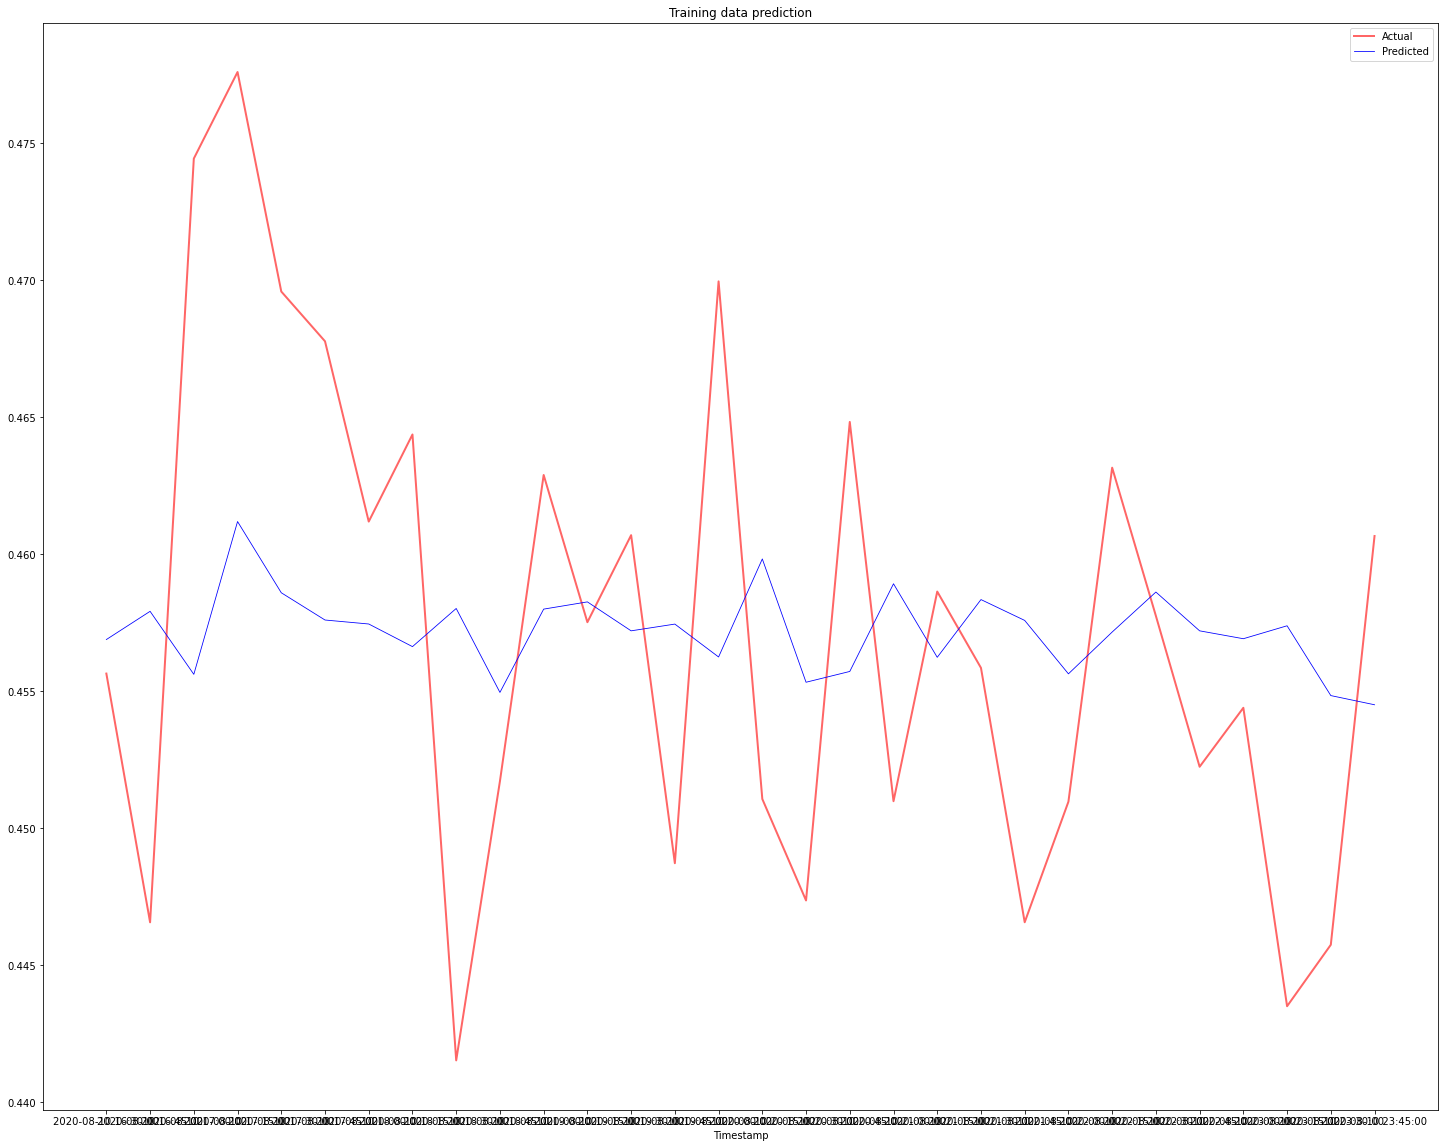

In [26]:
#Visulising the actual vs predicted for the last 30 values in the Train data
plt.figure(figsize=(25,20))
plt.plot(train_timestamps[-30:], y_train[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps[-30:], y_train_pred[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [27]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [28]:
mean_absolute_percentage_error1(y_test,y_test_pred)

3.7363135529034226

In [29]:
mean_absolute_percentage_error1(y_train,y_train_pred)

2.7579953162334947

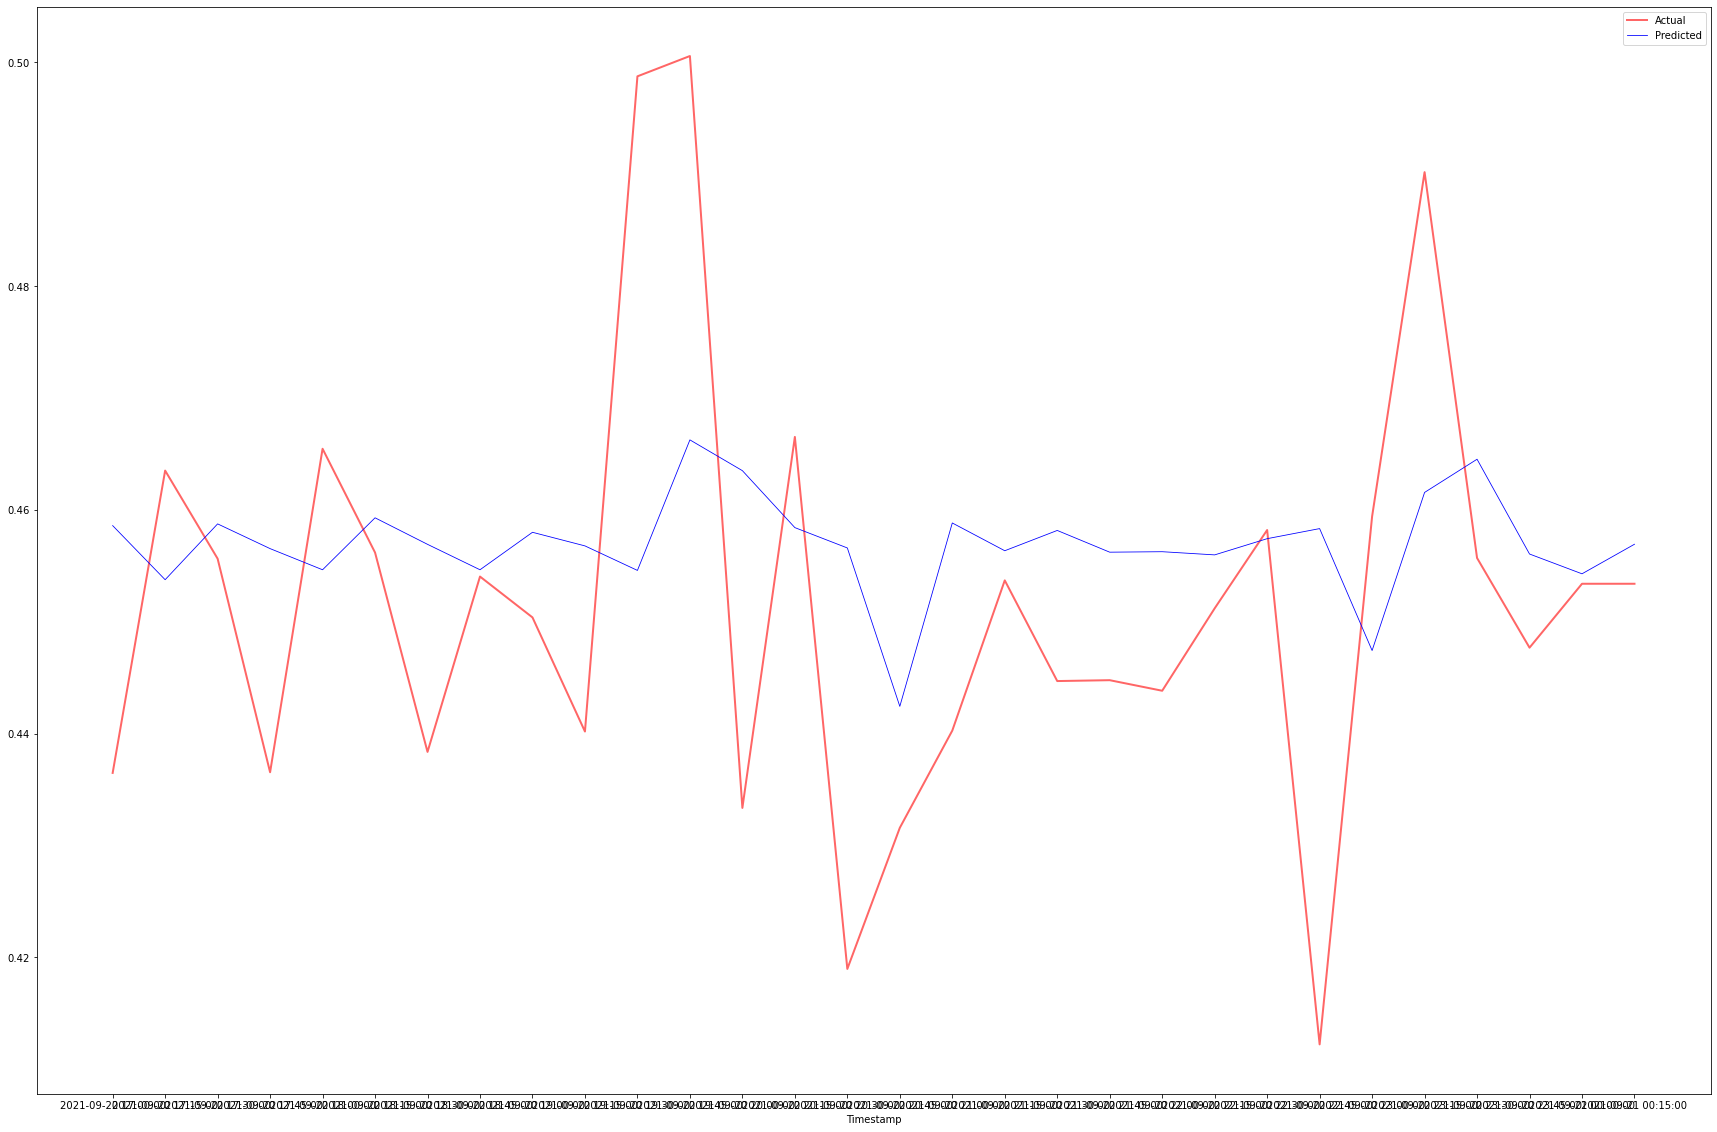

In [30]:
#Visulising the actual vs predicted for the last 30 values in the Test data
plt.figure(figsize=(30,20))
plt.plot(test_timestamps[-30:], y_test[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps[-30:], y_test_pred[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [31]:
mse = mean_squared_error(y_test, y_test_pred)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 0.0006976489594557112
RMSE: 0.02641304525146071


In [32]:
mse = mean_squared_error(y_train, y_train_pred)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 0.00033306794868089473
RMSE: 0.0182501492783181


## Hyperparameter tuning

In [33]:
#Hyperparameter tuning
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(0)
param_dist = {
            'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
tuning_model=RandomizedSearchCV(model,param_dist,scoring='neg_mean_absolute_percentage_error',cv=3,verbose=3,error_score='raise',)

tuning_model.fit(x_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-67776084236.883 total time=  33.5s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.034 total time=  32.4s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=1000;, score=-0.026 total time=  34.4s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=-70196012733.684 total time=   2.8s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=-0.046 total time=   2.9s
[CV 3/3] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100;, score=-0.042 total time=   3.0s
[CV 1/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100;, score=-64762606994.231 total time=   2.0s
[CV 2/3] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_es

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300...
                                          max_leaves=0, min_child_weight=1,
                                          missing=nan,
                                          monotone_constrain

In [34]:
tuning_model.best_params_

{'n_estimators': 100,
 'max_depth': 6,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7}

In [24]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [25]:
xgbr = xgb.XGBRegressor(colsample_bytree=0.7, learning_rate= 0.1, max_depth=6, n_estimators=100)
xgbr.fit(x_train, y_train[:,0])
 
y_pred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: " ,(mse))
print("RMSE: " , (mse**(1/2.0)))

MSE:  0.0006674719819483745
RMSE:  0.025835479131387798


In [29]:
y_train_pred1= xgbr.predict(x_train).reshape(-1,1)
y_test_pred1= xgbr.predict(x_test).reshape(-1,1)

print(y_train_pred1.shape, y_test_pred1.shape)

(91388, 1) (38974, 1)


In [32]:
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

91388 38974


In [30]:
mse = mean_squared_error(y_train, y_train_pred1)
print("MSE:" ,(mse))
print("RMSE: ",  (mse**(1/2.0)))

MSE: 0.0003852420964075705
RMSE:  0.019627585088532174


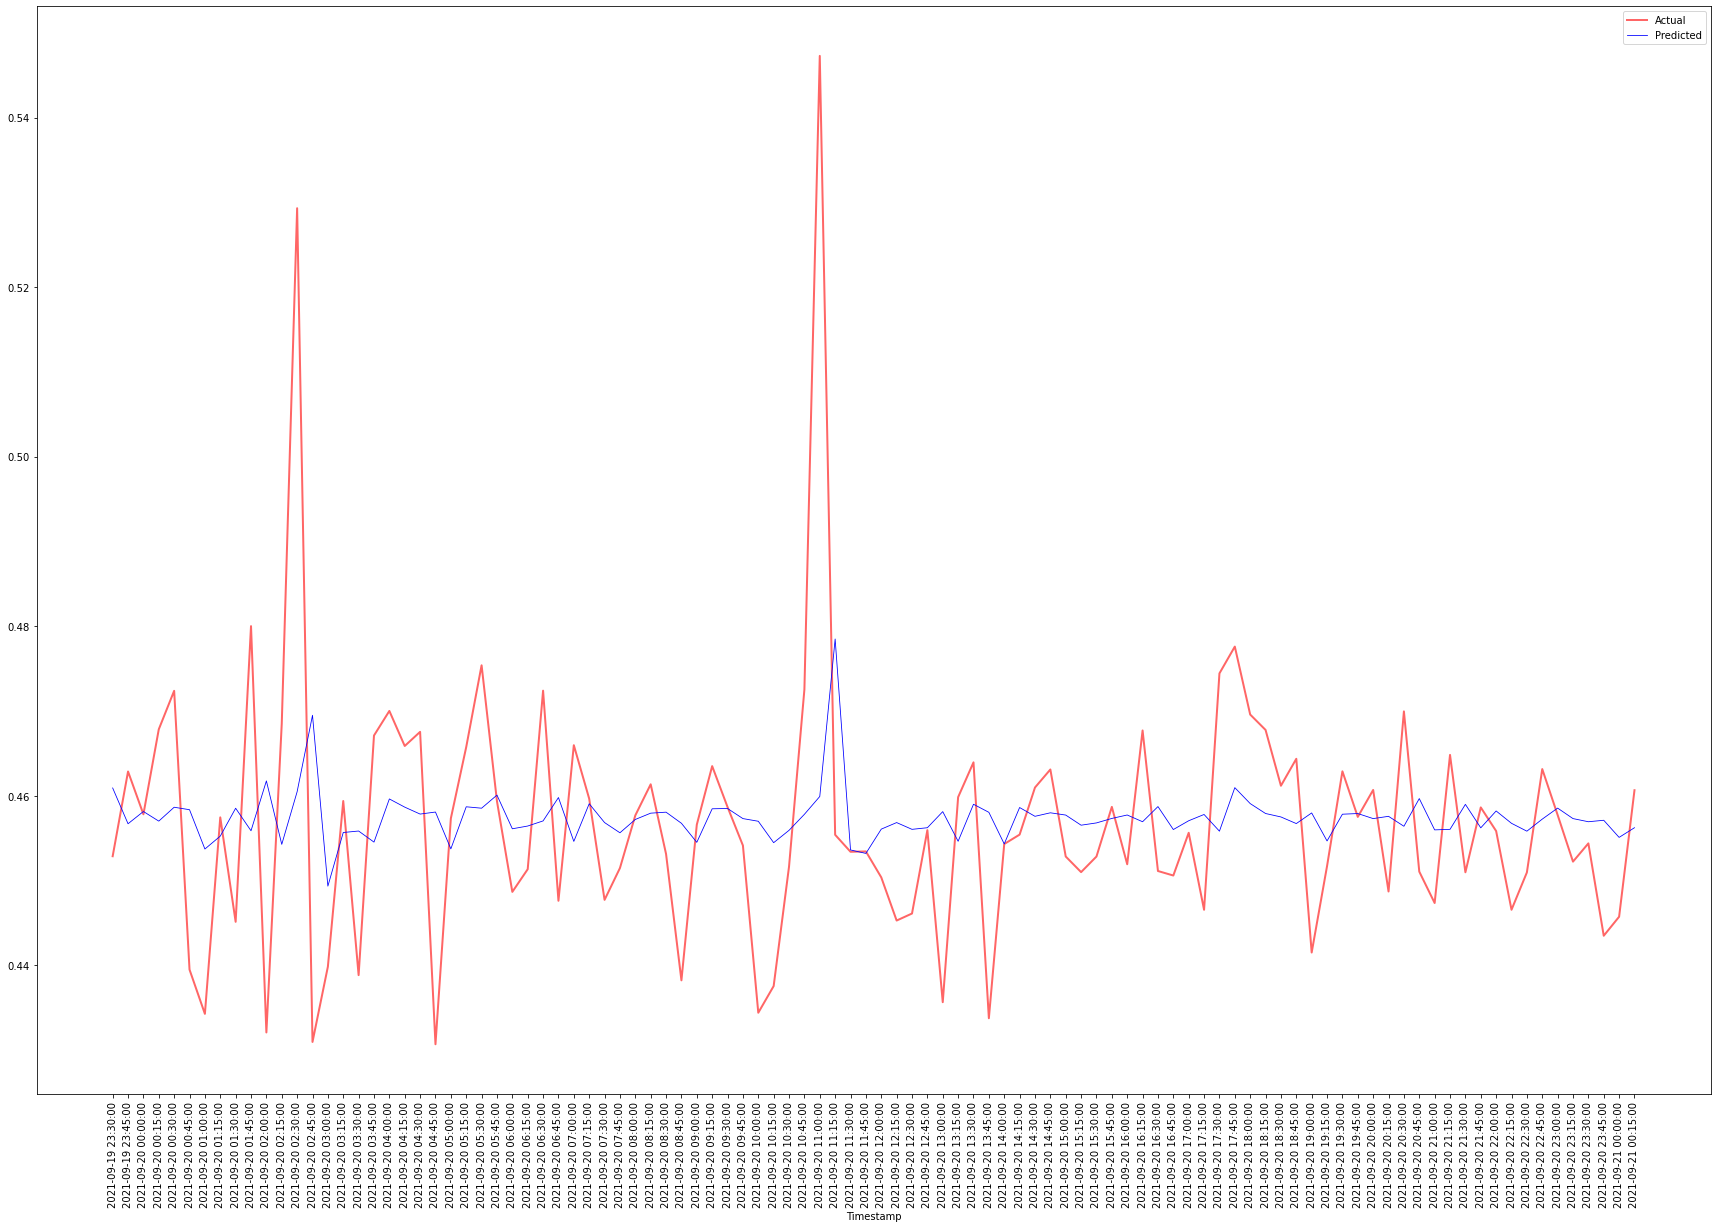

In [33]:
#Visulising the actual vs predicted for the last 100 values in the Test data
plt.figure(figsize=(30,20))
plt.plot(test_timestamps[-100:], y_train[-100:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps[-100:], y_train_pred1[-100:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xticks(rotation=90)
plt.show()

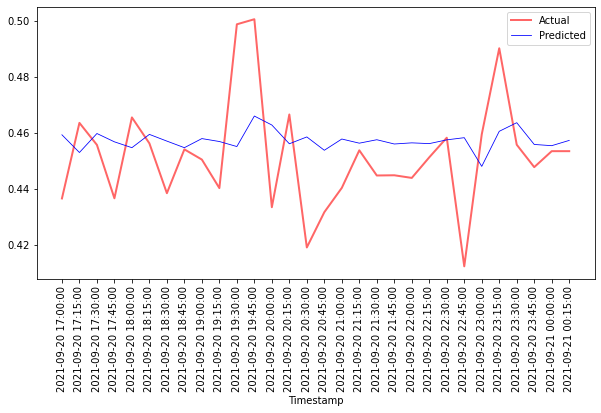

In [44]:
#Visulising the actual vs predicted for the last 30 values in the Test data
plt.figure(figsize=(10,5))
plt.plot(test_timestamps[-30:], y_test[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps[-30:], y_test_pred1[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xticks(rotation=90)
plt.show()

In [36]:
#TEST MAPE
mean_absolute_percentage_error1(y_test, y_pred)

3.683605454619631

In [37]:
#TRAIN MAPE
mean_absolute_percentage_error1(y_train, y_train_pred1)

2.880122440424493